In [1]:
!nvidia-smi

Mon Dec 11 15:29:41 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98                 Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               Off | 00000000:81:00.0 Off |                  Off |
| 30%   27C    P0              59W / 230W |      1MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Imports 
import torch
import transformers
from datasets import load_dataset
from PIL import Image
import json

"""
Unused imports:
import torch.nn as nn
import bitsandbytes as bnb
"""


from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, BitsAndBytesConfig

from peft import (
    LoraConfig,
    PeftConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_int8_training,
    prepare_model_for_kbit_training,
    set_peft_model_state_dict,
    get_peft_config, 
    TaskType, 
    PeftType,
    PeftModel
)

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# device_map = {"": 0}
device_map = "auto"
DEFAULT_IMAGE_TOKEN = "<image>"
base_model = "mistralai/Mistral-7B-Instruct-v0.1"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4'
)

tokenizer = AutoTokenizer.from_pretrained(base_model)
tokenizer.add_special_tokens(
    {
     
        "pad_token": "<PAD>",
    }
)
tokenizer.add_tokens([DEFAULT_IMAGE_TOKEN], special_tokens=True)
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    low_cpu_mem_usage=True,
    device_map=device_map
)
model.config.pad_token_id = tokenizer.pad_token_id
model.resize_token_embeddings(len(tokenizer))
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32002, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

In [4]:
# model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)
# mistral_peft_config = LoraConfig(
#     lora_alpha=64,
#     lora_dropout=0.1,
#     r=32,
#     bias="none",
#     task_type="CAUSAL_LM", 
#     target_modules=[
#         "q_proj",
#         "k_proj",
#         "v_proj",
#         "o_proj",
#         "gate_proj",
#         "up_proj",
#         "down_proj",
#         "lm_head",
#     ],
# )
# model = get_peft_model(model, mistral_peft_config)
# model.print_trainable_parameters()

In [5]:
tokenizer

LlamaTokenizerFast(name_or_path='mistralai/Mistral-7B-Instruct-v0.1', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<PAD>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32000: AddedToken("<PAD>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32001: AddedToken("<image>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [6]:
img_token_id = tokenizer(DEFAULT_IMAGE_TOKEN, add_special_tokens=False)["input_ids"][0]
img_token_id

32001

In [7]:
# from datasets import load_dataset
# dataset = load_dataset("json", data_files="dataset/llava_instruct_80k.json", split="train")

In [8]:
# #################################################################
# # Mistral tokenization scheme                                   #  
# # Taken from https://docs.mistral.ai/llm/mistral-instruct-v0.1  #
# #################################################################
# # [START_SYMBOL_ID] +                                           #
# # tok("[INST]") + tok(USER_MESSAGE_1) + tok("[/INST]") +        #
# # tok(BOT_MESSAGE_1) + [END_SYMBOL_ID] +                        #
# # …                                                             #
# # tok("[INST]") + tok(USER_MESSAGE_N) + tok("[/INST]") +        #
# # tok(BOT_MESSAGE_N) + [END_SYMBOL_ID]                          #
# #################################################################


# def conversation_mapper(row):
#     if row["from"] == "human":
#         role = "user"
#     else:
#         role = "assistant"
#     return { "role": role, "content": row["value"] }

# def get_tokens(messages, tokenizer, max_length):
#     input_ids = [tokenizer.bos_token_id]
#     attention_mask = []
#     labels = [tokenizer.bos_token_id]
#     for m in messages:
#         iids = []
#         content = m["content"]
#         if DEFAULT_IMAGE_TOKEN in content:
#             content = content.replace(DEFAULT_IMAGE_TOKEN, '').strip()
#             content = DEFAULT_IMAGE_TOKEN + '\n' + content
#             content = content.strip()
#         msg = tokenizer(content, add_special_tokens=False)["input_ids"]
#         if m["role"] == "user":
#             b_inst = tokenizer("[INST]", add_special_tokens=False)["input_ids"]
#             e_inst = tokenizer("[/INST]", add_special_tokens=False)["input_ids"]
#             iids = b_inst + msg + e_inst
#             # label_iids = [-100] * len(iids)
#         else:
#             iids = msg + [tokenizer.eos_token_id]
#             # label_iids = iids
#         input_ids += iids
#         # labels += label_iids
#     attention_mask = [1] * len(input_ids)

#     # Pad to max length
#     pad_len = max_length - len(input_ids)
#     if pad_len > 0:
#         input_ids += [tokenizer.pad_token_id] * pad_len
#         labels += [-100] * pad_len
#         attention_mask += [0] * pad_len
#     return {
#         "input_ids": input_ids[:max_length],
#         "attention_mask": attention_mask[:max_length],
#         "labels": input_ids[:max_length].copy(),
#         "img_token_position": input_ids[:max_length].index(img_token_id),
#         "pad_length": pad_len
#     }


# def process_data(tokenizer, max_length):
#     def mapper(row):
#         image = row["image"]
        
#         image_filepath = f"/fs/cml-datasets/coco/images/train2017/{image}"
#         conversations = list(map(conversation_mapper, row["conversations"]))
#         prompt = tokenizer.apply_chat_template(conversations, tokenize=False, add_generation_prompt=True)
#         tokens_data = get_tokens(conversations, tokenizer, max_length)
#         row["image_filepath"] = image_filepath
#         # row["prompt"] = prompt
#         row["input_ids"] = tokens_data["input_ids"]
#         row["attention_mask"] = tokens_data["attention_mask"]
#         row["labels"] = tokens_data["labels"]
#         row["img_token_position"] = tokens_data["img_token_position"]
#         row["pad_length"] = tokens_data["pad_length"]
#         return row
#     return mapper

# max_length = 300
# ds = dataset.map(process_data(tokenizer, max_length), remove_columns=["conversations"])

In [9]:
# ds_filtered = ds.filter(lambda example: example["pad_length"] >= 0)

In [10]:
# import numpy as np
# import matplotlib.pyplot as plt

# plt.hist(ds["token_length"]);
# plt.show()
# plt.hist(ds["pad_length"]);
# plt.show()
# print("Pad length = 0 count: ", len([i for i in ds["pad_length"] if i == 0]))
# print("Average pad length = : ", sum(ds["pad_length"])/len(ds["pad_length"]))

In [11]:
# split_ds = ds_filtered.train_test_split(test_size=0.2)
# train_val_ds = split_ds["train"].train_test_split(test_size=0.25)
# train_ds = train_val_ds["train"]
# val_ds = train_val_ds["test"]
# test_ds = split_ds["test"]

# # Save dataset
# train_ds.to_json("./dataset/llava-instruct-50k-train.json")
# val_ds.to_json("./dataset/llava-instruct-50k-val.json")
# test_ds.to_json("./dataset/llava-instruct-50k-test.json")
# print(len(train_ds), len(val_ds), len(test_ds))

In [12]:
train_ds = load_dataset("json", data_files="./dataset/llava-instruct-50k-train.json", split="train")
val_ds = load_dataset("json", data_files="./dataset/llava-instruct-50k-val.json", split="train")
test_ds = load_dataset("json", data_files="./dataset/llava-instruct-50k-test.json", split="train")

In [12]:
from torch.utils.data import DataLoader

def custom_collate_fn(examples):
    return {
        "image": [i["image"] for i in examples],
        "id": [i["id"] for i in examples],
        "image_filepath": [i["image_filepath"] for i in examples],
        "input_ids": torch.vstack([torch.tensor(i["input_ids"]) for i in examples]),
        "attention_mask": torch.vstack([torch.tensor(i["attention_mask"]) for i in examples]),
        "labels": torch.vstack([torch.tensor(i["labels"]) for i in examples]),
        "img_token_position": [i["img_token_position"] for i in examples]
    }
    
train_dataloader = DataLoader(
    train_ds,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=custom_collate_fn
)
val_dataloader = DataLoader(
    val_ds,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    collate_fn=custom_collate_fn
)

In [15]:
# Load ViT + LoRA
from transformers import AutoImageProcessor, ViTModel

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k", device_map=device_map)
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "key", "value"],
    lora_dropout=0.2,
    bias="all",
)
vit = get_peft_model(vit, config)
vit.print_trainable_parameters()

trainable params: 988,416 || all params: 87,273,984 || trainable%: 1.1325436913708442


In [16]:
import torch.nn as nn
vit_to_llm = nn.Linear(768, 4096).to(3)

In [17]:
W = vit_to_llm
# Before training
_before = list(W.parameters())[:25]
_before

[Parameter containing:
 tensor([[ 0.0083,  0.0329,  0.0128,  ..., -0.0052, -0.0158,  0.0055],
         [-0.0113, -0.0356,  0.0249,  ..., -0.0064, -0.0218, -0.0147],
         [ 0.0227, -0.0164, -0.0288,  ..., -0.0345, -0.0083,  0.0125],
         ...,
         [-0.0009,  0.0190,  0.0065,  ...,  0.0033,  0.0021, -0.0192],
         [ 0.0314,  0.0065,  0.0094,  ..., -0.0114,  0.0171,  0.0255],
         [ 0.0236,  0.0114,  0.0322,  ..., -0.0115, -0.0271,  0.0087]],
        device='cuda:3', requires_grad=True),
 Parameter containing:
 tensor([ 0.0163, -0.0246,  0.0183,  ...,  0.0177,  0.0007,  0.0075],
        device='cuda:3', requires_grad=True)]

In [18]:
from tqdm.auto import tqdm
from torch.optim import AdamW
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import torch.nn.functional as F
import random
from torch.autograd import Variable
from itertools import chain

lr = 1e-3

# embedding_layer = model.base_model.model.model.embed_tokens # For LoRA
embedding_layer = model.model.embed_tokens                    # For frozen language model
params = chain( 
    # model.parameters(),
    vit.parameters(),
    vit_to_llm.parameters()
)

optimizer = AdamW(params=params, lr=lr)

losses_total = []
grads_total = []
num_epochs = 1
total_loss = 0.0
count = 1


for epoch in tqdm(range(num_epochs)):
  with tqdm(train_dataloader, leave=False) as t:
      t.set_description('Training loop')
      for i, batch in enumerate(t):
          img_token_position = batch["img_token_position"][0]
          input_ids = batch["input_ids"]
          labels = batch["labels"]
          attention_mask = batch["attention_mask"]
          img_paths = [p for p in batch["image_filepath"]]
          images = [Image.open(p).convert("RGB") for p in img_paths]
          processed_images = [image_processor(img, return_tensors="pt").to(vit.device) for img in images]
          vit_outs = [vit(**inputs) for inputs in processed_images]
          last_hidden = [outputs.last_hidden_state for outputs in vit_outs]
          img_embeddings = torch.cat([h[:, 0, :] for h in last_hidden], dim=0)
          mapped_img_embeddings = vit_to_llm(img_embeddings.to(3)).half().unsqueeze(1)
          text_embeddings = embedding_layer(batch["input_ids"])
          img_token_indexes = batch["input_ids"] == img_token_id

          input_embeds = torch.cat([
              text_embeddings[:, :img_token_position, :].to(model.device),
              mapped_img_embeddings.to(model.device), 
              text_embeddings[:, img_token_position + 1:, :].to(model.device)], dim=1
          )

          out = model(inputs_embeds=input_embeds, attention_mask=attention_mask, labels=labels)
          loss = out.loss
          total_loss += loss.item()
          avg_loss = total_loss / count
          count += 1
          t.set_postfix(loss=avg_loss)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          losses_total.append(loss.item())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3968 [00:00<?, ?it/s]

In [20]:
# model.save_pretrained("./models/mistral-lora-latest/")
vit.save_pretrained("./models/vit-lora-latest/")
torch.save(vit_to_llm.state_dict(), './models/vit-to-llm-latest.pt')

In [ ]:
# train_ds.to_json("./dataset/llava-instruct-50k-train.json")
# val_ds.to_json("./dataset/llava-instruct-50k-val.json")
# test_ds.to_json("./dataset/llava-instruct-50k-test.json")

In [22]:
#################################################################
# Mistral tokenization scheme                                   #  
# Taken from https://docs.mistral.ai/llm/mistral-instruct-v0.1  #
#################################################################
# [START_SYMBOL_ID] +                                           #
# tok("[INST]") + tok(USER_MESSAGE_1) + tok("[/INST]") +        #
# tok(BOT_MESSAGE_1) + [END_SYMBOL_ID] +                        #
# …                                                             #
# tok("[INST]") + tok(USER_MESSAGE_N) + tok("[/INST]") +        #
# tok(BOT_MESSAGE_N) + [END_SYMBOL_ID]                          #
#################################################################


def conversation_mapper_v2(row):
    if row["from"] == "human":
        role = "user"
    else:
        role = "assistant"
    return { "role": role, "content": row["value"] }

def get_tokens_v2(messages, tokenizer, max_length, padding=False):
    input_ids = [tokenizer.bos_token_id]
    attention_mask = []
    labels = [tokenizer.bos_token_id]
    for m in messages:
        iids = []
        content = m["content"]
        if DEFAULT_IMAGE_TOKEN in content:
            content = content.replace(DEFAULT_IMAGE_TOKEN, '').strip()
            content = DEFAULT_IMAGE_TOKEN + '\n' + content
            content = content.strip()
        msg = tokenizer(content, add_special_tokens=False)["input_ids"]
        if m["role"] == "user":
            b_inst = tokenizer("[INST]", add_special_tokens=False)["input_ids"]
            e_inst = tokenizer("[/INST]", add_special_tokens=False)["input_ids"]
            iids = b_inst + msg + e_inst
            label_iids = [-100] * len(iids)
        else:
            iids = msg + [tokenizer.eos_token_id]
            label_iids = iids
        input_ids += iids
        labels += label_iids
    attention_mask = [1] * len(input_ids)

    # Pad to max length
    pad_len = max_length - len(input_ids)
    if padding and pad_len > 0:
        input_ids += [tokenizer.pad_token_id] * pad_len
        labels += [-100] * pad_len
        attention_mask += [0] * pad_len
    return {
        "input_ids": input_ids[:max_length],
        "attention_mask": attention_mask[:max_length],
        "labels": labels[:max_length],
        "img_token_position": input_ids[:max_length].index(img_token_id),
        "pad_length": pad_len
    }


def process_data_v2(tokenizer, max_length, padding=False):
    def mapper(row):
        image = row["image"]
        
        image_filepath = f"{image}"
        conversations = list(map(conversation_mapper_v2, row["conversations"]))
        tokens_data = get_tokens_v2(conversations, tokenizer, max_length, padding)
        row["image_filepath"] = image_filepath
        row["input_ids"] = tokens_data["input_ids"]
        row["attention_mask"] = tokens_data["attention_mask"]
        row["labels"] = tokens_data["labels"]
        row["img_token_position"] = tokens_data["img_token_position"]
        return row
    return mapper

item = {
    "image" : "./cat.jpg",
    "id": "1234",
    "conversations": [
        {
            "from": "human",
            "value": "<image>\nWhat do you see in the image?"
        }
    ]
}
_processor = process_data_v2(tokenizer, 300)
processed_item = _processor(item)
processed_item

{'image': './cat.jpg',
 'id': '1234',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhat do you see in the image?'}],
 'image_filepath': './cat.jpg',
 'input_ids': [1,
  733,
  16289,
  28793,
  32000,
  28705,
  13,
  3195,
  511,
  368,
  1032,
  297,
  272,
  3469,
  28804,
  733,
  28748,
  16289,
  28793],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [1,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100],
 'img_token_position': 4}

/nfshomes/skarki/scratch/miniconda3/envs/llame/lib/python3.9/site-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


tensor([[    1,   560,   272,  3469, 28725,   736,   349,   264,  2687,   304,
          3075,  5255,  6398,   356,   264, 11984,   297,   264,  4890, 28723,
           415,  5255,   349,  2526,   582,   438,   272,  7555, 28725,   304,
           871,  2282,   460,  5051, 28723,   415,  5255,   349,  8192,   264,
         24018,   395,   264,  5846, 28725,   304,   378,  8045,   298,   347,
           264, 10131,   304, 18788,  8527, 28723,   415,  5414,   302,   272,
          3469,  4370,   264,  4890,   395,  7099,   304,   264, 11984, 28725,
           304,   272,  6337,   349,  9753,   887,   297, 22950, 28723,     2]],
       device='cuda:0')


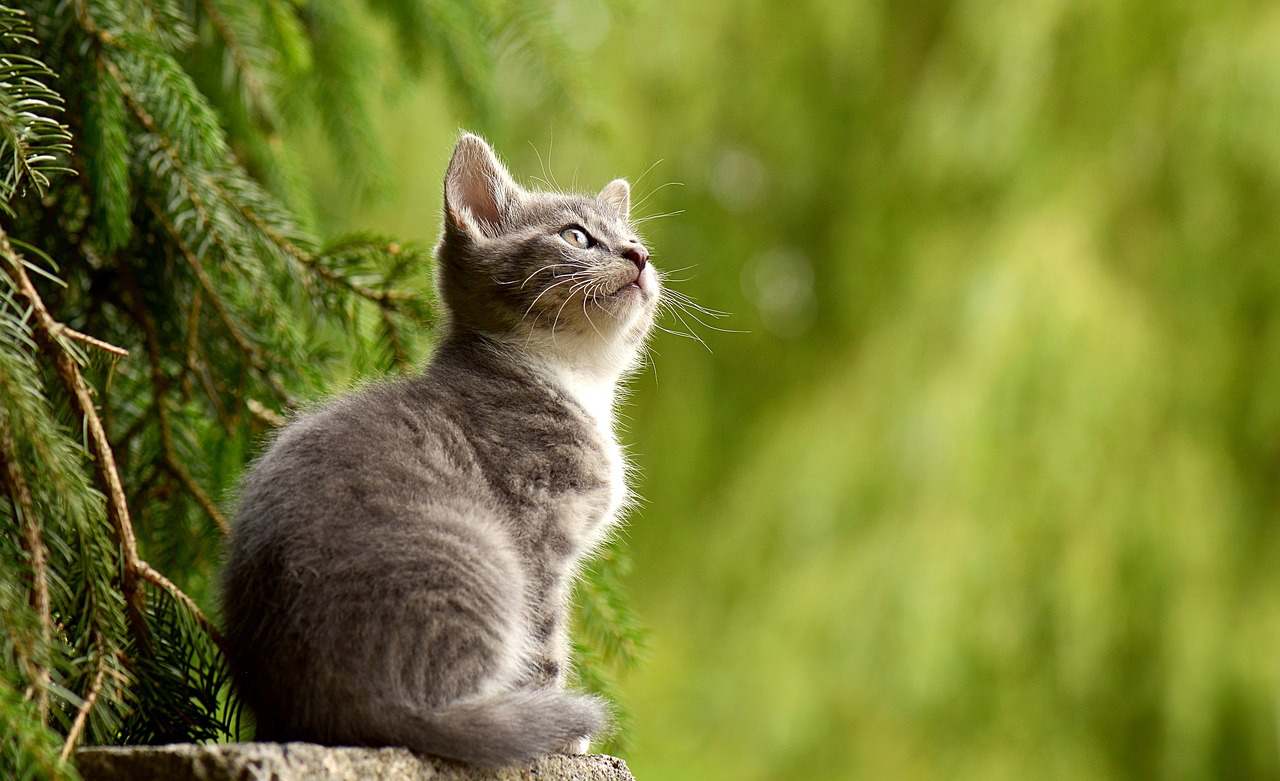

In the image, there is a black and white cat sitting on a bench in a park. The cat is looking up at the camera, and its eyes are closed. The cat is wearing a collar with a tag, and it appears to be a friendly and relaxed animal. The background of the image shows a park with trees and a bench, and the scene is bathed in sunlight.


In [23]:
img_token_position = processed_item["img_token_position"]
input_ids = torch.tensor(processed_item["input_ids"]).reshape(1, -1)
attention_mask = torch.tensor(processed_item["attention_mask"]).reshape(1, -1)
img_paths = [processed_item["image_filepath"]]
images = [Image.open(processed_item["image_filepath"]).convert("RGB")]
processed_images = [image_processor(img, return_tensors="pt").to(vit.device) for img in images]
vit_outs = [vit(**inputs) for inputs in processed_images]
last_hidden = [outputs.last_hidden_state for outputs in vit_outs]
img_embeddings = torch.cat([h[:, 0, :] for h in last_hidden], dim=0)
mapped_img_embeddings = vit_to_llm(img_embeddings.to(3)).half().unsqueeze(1)
text_embeddings = embedding_layer(input_ids)
img_token_indexes = input_ids == img_token_id

input_embeds = torch.cat([
  text_embeddings[:, :img_token_position, :].to(model.device),
  mapped_img_embeddings.to(model.device), 
  text_embeddings[:, img_token_position + 1:, :].to(model.device)], dim=1
)
_gen = model.generate(
    inputs_embeds=input_embeds,
    return_dict_in_generate=True,
    output_scores=True,
    output_hidden_states=True,
    max_new_tokens=300
)
hs = _gen.hidden_states
seq = _gen.sequences
print(seq)
display(images[0])
print(tokenizer.batch_decode(seq, skip_special_tokens=True)[0])

In [ ]:
# input_ids = torch.tensor(processed_item["input_ids"]).reshape(1, -1)
# attention_mask = torch.tensor(processed_item["attention_mask"]).reshape(1, -1)
# text_embeddings = embedding_layer(input_ids)
# _gen = model.generate(
#     inputs_embeds=text_embeddings,
#     return_dict_in_generate=True,
#     output_scores=True,
#     output_hidden_states=True,
#     max_new_tokens=300
# )
# hs = _gen.hidden_states
# seq = _gen.sequences
# print(seq)
# print(tokenizer.batch_decode(seq, skip_special_tokens=True)[0])

tensor([[    1,   560,   272,  3469, 28725,   736,   349,   264,  7899, 28733,
         18873, 10660,  2819,   395,   264,  2475,  7899, 28733, 18873, 13093,
           297,   272,  5414, 28723,   415, 10660,  2819,   349, 14161,   486,
           264,  9555, 28725,  1565, 13894,   395,   264,  1664,  7099,   297,
           272,  2417,  2812, 28723,   415,  6337,   349,   808,   297,   264,
          8539,  3302, 28725,   390, 14075,   486,   272,  7899, 13974,   272,
         13894, 28723,     2]], device='cuda:0')


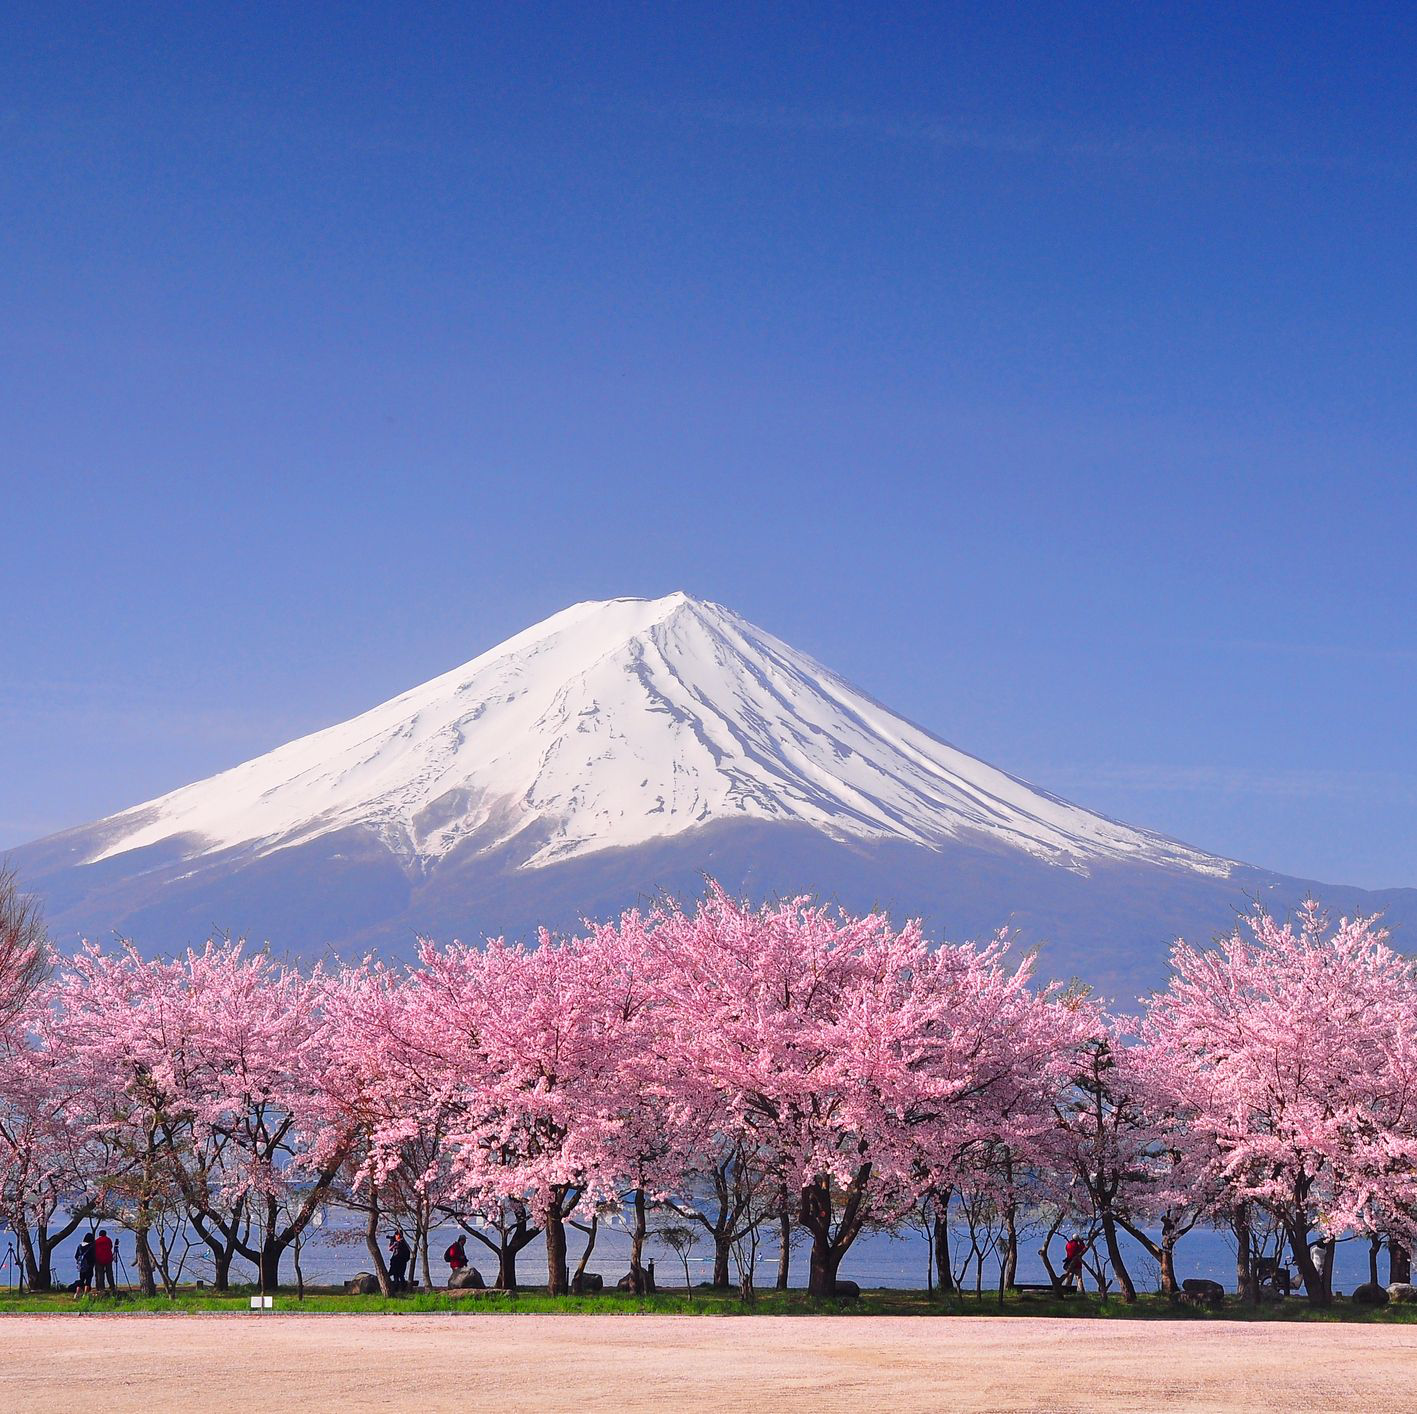

In the image, there is a snow-covered mountain range with a large snow-covered peak in the background. The mountain range is surrounded by a vast, open landscape with a few trees in the foreground. The scene is set in a winter season, as indicated by the snow covering the landscape.


In [26]:
item = {
    "image" : "./test-img-6.jpg",
    "id": "1234",
    "conversations": [
        {
            "from": "human",
            "value": "<image>\nWhat do you see in the image?"
        }
    ]
}
_processor = process_data_v2(tokenizer, 300)
processed_item = _processor(item)
img_token_position = processed_item["img_token_position"]
input_ids = torch.tensor(processed_item["input_ids"]).reshape(1, -1)
attention_mask = torch.tensor(processed_item["attention_mask"]).reshape(1, -1)
img_paths = [processed_item["image_filepath"]]
images = [Image.open(processed_item["image_filepath"]).convert("RGB")]
processed_images = [image_processor(img, return_tensors="pt").to(vit.device) for img in images]
vit_outs = [vit(**inputs) for inputs in processed_images]
last_hidden = [outputs.last_hidden_state for outputs in vit_outs]
img_embeddings = torch.cat([h[:, 0, :] for h in last_hidden], dim=0)
mapped_img_embeddings = vit_to_llm(img_embeddings.to(3)).half().unsqueeze(1)
text_embeddings = embedding_layer(input_ids)
img_token_indexes = input_ids == img_token_id

input_embeds = torch.cat([
  text_embeddings[:, :img_token_position, :].to(model.device),
  mapped_img_embeddings.to(model.device), 
  text_embeddings[:, img_token_position + 1:, :].to(model.device)], dim=1
)
_gen = model.generate(
    inputs_embeds=input_embeds,
    return_dict_in_generate=True,
    output_scores=True,
    output_hidden_states=True,
    max_new_tokens=300
)
hs = _gen.hidden_states
seq = _gen.sequences
print(seq)
display(images[0])
print(tokenizer.batch_decode(seq, skip_special_tokens=True)[0])

In [29]:
dataset = load_dataset("json", data_files="dataset/llava_instruct_80k.json", split="train")

In [30]:
dataset[0]

{'image': '000000379143.jpg',
 'id': '000000379143',
 'conversations': [{'from': 'human',
   'value': 'What is the man doing in the back of the pickup truck?\n<image>'},
  {'from': 'gpt',
   'value': 'The man is sitting on top of piled objects or belongings loaded into the back of a pickup truck.'},
  {'from': 'human', 'value': 'Is the man holding anything in his hands?'},
  {'from': 'gpt',
   'value': 'Yes, the man is holding a beer in his hand while sitting on top of the objects in the back of the pickup truck.'},
  {'from': 'human', 'value': 'What color is the pickup truck?'},
  {'from': 'gpt', 'value': 'The pickup truck is white.'},
  {'from': 'human', 'value': 'Is the man sitting or standing?'},
  {'from': 'gpt',
   'value': 'The man is sitting on top of the piled objects in the back of the pickup truck.'},
  {'from': 'human',
   'value': 'What could be the possible reasons for the man sitting on top of the possessions in the back of the pickup truck?'},
  {'from': 'gpt',
   'valu

In [31]:
len(train_ds)

31737